In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os 
import tensorflow as tf

In [2]:
df = pd.read_csv('Resources/train.csv')  
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Extract title from name
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Create FamilySize feature
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1


<>:2: SyntaxWarning: invalid escape sequence '\.'
<>:2: SyntaxWarning: invalid escape sequence '\.'
C:\Users\the_a\AppData\Local\Temp\ipykernel_5864\506576082.py:2: SyntaxWarning: invalid escape sequence '\.'
  df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


In [4]:
df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)

# # Save cleaned dataset to CSV for pgAdmin import
df_cleaned = df.copy()
# df_cleaned.to_csv('titanic_cleaned.csv', index=False)
# print("✅ Exported: titanic_cleaned.csv")

# Fill missing values
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Fare'].fillna(df['Fare'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# Encode categoricals
le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])
df['Embarked'] = le.fit_transform(df['Embarked'])
df['Title'] = le.fit_transform(df['Title'])

# Normalize numeric columns
scaler = StandardScaler()
df[['Age', 'Fare', 'FamilySize']] = scaler.fit_transform(df[['Age', 'Fare', 'FamilySize']])

C:\Users\the_a\AppData\Local\Temp\ipykernel_5864\1083848343.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
C:\Users\the_a\AppData\Local\Temp\ipykernel_5864\1083848343.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

In [5]:
X = df.drop(columns='Survived')
y = df['Survived']
y_flipped = 1 - y  # Flip labels to find unexpected survivors
X_train, X_test, y_train, y_test = train_test_split(X, y_flipped, test_size=0.2, random_state=42)


In [6]:
# Model training and evaluation

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=3),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42)
}

model_results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    model_results.append({'Model': name, 'Accuracy': round(acc * 100, 2)})
    print(f"📌 {name}\nAccuracy: {acc:.2f}")
    print(classification_report(y_test, preds))

results_df = pd.DataFrame(model_results)

📌 Logistic Regression
Accuracy: 0.80
              precision    recall  f1-score   support

           0       0.77      0.73      0.75        74
           1       0.82      0.85      0.83       105

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179

📌 K-Nearest Neighbors
Accuracy: 0.81
              precision    recall  f1-score   support

           0       0.80      0.72      0.76        74
           1       0.81      0.88      0.84       105

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179

📌 Decision Tree
Accuracy: 0.80
              precision    recall  f1-score   support

           0       0.83      0.65      0.73        74
           1       0.79      0.90      0.84       105

    accuracy                           0.80       179
   macro avg       0.81

In [7]:
# Use best model (example: Decision Tree)
best_model = models['Decision Tree']
y_pred = best_model.predict(X_test)

# Revert flipped labels to real Survived status
real_y_test = 1 - y_test

# Predicted NotSurvived but actually Survived = unexpected beneficiaries
predicted_not_survived = y_pred == 1
actually_survived = real_y_test == 1
beneficiaries_index = X_test[predicted_not_survived & actually_survived].index

beneficiaries_df = df.loc[beneficiaries_index]
beneficiaries_df[['Pclass', 'Sex', 'Age', 'Fare', 'FamilySize', 'Survived']].head()

,Pclass,Sex,Age,Fare,FamilySize,Survived
709,3,1,-0.104637,-0.341452,0.679295,1
621,1,1,0.971260,0.409741,0.059160,1
447,1,1,0.356462,-0.113846,-0.560975,1
192,3,0,-0.796286,-0.490280,0.059160,1
673,2,1,0.125912,-0.386671,-0.560975,1


In [ ]:
# Create an SQLite engine
engine1 = create_engine('sqlite:///Exports/titanic_cleaned.db', echo=False)
engine2 = create_engine('sqlite:///Exports/model_results.db', echo=False)
engine3 = create_engine('sqlite:///Exports/beneficiary_survivors.db', echo=False)

# Write the DataFrame to SQLite
df_cleaned.to_sql('cleaned data', engine1, if_exists='replace', index=False)
results_df.to_sql('model data', engine2, if_exists='replace', index=False)
beneficiaries_df.to_sql('beneficiary data', engine3, if_exists='replace', index=False)

# Dispose of the engine
engine2.dispose()
engine3.dispose()


In [ ]:
#showing the cleaned data in the SQLite database
df_cleaned_SQL_PROOF=pd.read_sql('cleaned data', engine1)
engine1.dispose()
df_cleaned_SQL_PROOF.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize
0,0,3,male,22.0,1,0,7.2500,S,Mr,2
1,1,1,female,38.0,1,0,71.2833,C,Mrs,2
2,1,3,female,26.0,0,0,7.9250,S,Miss,1
3,1,1,female,35.0,1,0,53.1000,S,Mrs,2
4,0,3,male,35.0,0,0,8.0500,S,Mr,1


📂 Cleaned Titanic Data


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize
0,0,3,1,-0.565736,1,0,-0.502445,2,12,0.059160
1,1,1,0,0.663861,1,0,0.786845,0,13,0.059160
2,1,3,0,-0.258337,0,0,-0.488854,2,9,-0.560975
3,1,1,0,0.433312,1,0,0.420730,2,13,0.059160
4,0,3,1,0.433312,0,0,-0.486337,2,12,-0.560975


📂 Model Evaluation Results


,Model,Accuracy
0,Logistic Regression,79.89
1,K-Nearest Neighbors,81.01
2,Decision Tree,79.89


📂 Unexpected Survivors


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize
709,1,3,male,-0.104637,1,1,-0.341452,0,8,0.679295
621,1,1,male,0.971260,1,0,0.409741,2,12,0.059160
447,1,1,male,0.356462,0,0,-0.113846,2,12,-0.560975
192,1,3,female,-0.796286,1,0,-0.490280,2,9,0.059160
673,1,2,male,0.125912,0,0,-0.386671,2,12,-0.560975


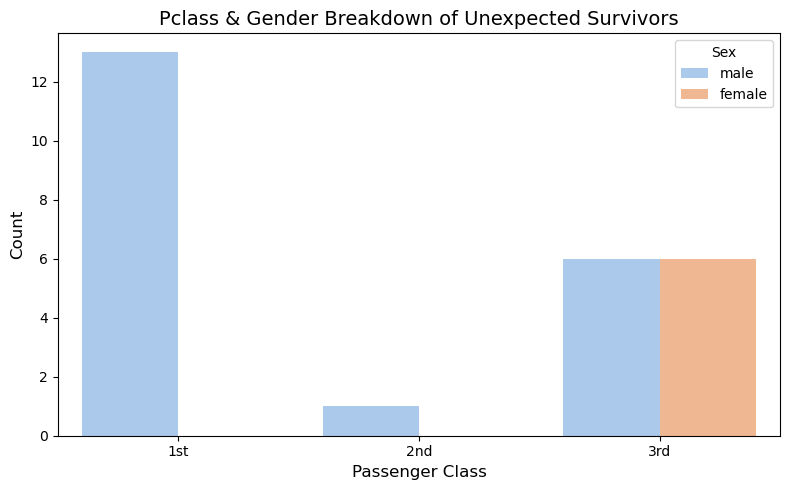

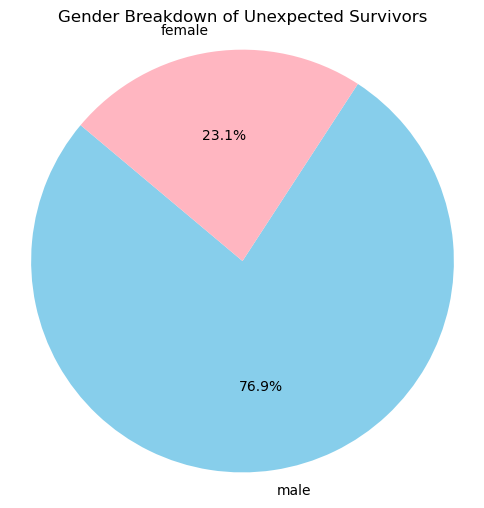

In [ ]:

beneficiaries_df['Sex'] = beneficiaries_df['Sex'].map({0: 'female', 1: 'male'})
# ✅ Preview data
print("📂 Cleaned Titanic Data")
display(df_cleaned.head())

print("📂 Model Evaluation Results")
display(results_df)

print("📂 Unexpected Survivors")
display(beneficiaries_df.head())

# 📊 Visualize: Pclass & Gender of mystery survivors
plt.figure(figsize=(8, 5))
sns.countplot(data=beneficiaries_df, x='Pclass', hue='Sex', palette='pastel')

plt.title("Pclass & Gender Breakdown of Unexpected Survivors", fontsize=14)
plt.xlabel("Passenger Class", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(ticks=[0, 1, 2], labels=["1st", "2nd", "3rd"])
plt.legend(title="Sex")
plt.tight_layout()
plt.show()

gender_counts = beneficiaries_df['Sex'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', colors=['#87CEEB', '#FFB6C1'], startangle=140)
plt.title("Gender Breakdown of Unexpected Survivors")
plt.axis('equal')  # Equal aspect ratio makes the pie a circle
plt.show()

In [ ]:

# -------------------------------
# Neural Network on Beneficiaries
# -------------------------------


# Load the dataset
df_beneficiaries = pd.read_csv("Exports/beneficiary_survivors.csv")

# Drop unneeded columns (keep similar ones used in your original model)
X = df_beneficiaries.drop(columns=['Survived', 'PassengerId', 'Name'], errors='ignore')
y = df_beneficiaries['Survived']

# Convert categorical columns using one-hot encoding
X = pd.get_dummies(X)

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=1)

# Define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Compile
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Neural Network Accuracy on Mystery Survivors: {accuracy:.4f}")


c:\Users\the_a\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.0667 - loss: 0.9386 - val_accuracy: 0.2500 - val_loss: 0.7733
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.0667 - loss: 0.9145 - val_accuracy: 0.2500 - val_loss: 0.7557
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.0667 - loss: 0.8908 - val_accuracy: 0.2500 - val_loss: 0.7400
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step - accuracy: 0.1333 - loss: 0.8681 - val_accuracy: 0.2500 - val_loss: 0.7247
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.2000 - loss: 0.8461 - val_accuracy: 0.2500 - val_loss: 0.7096
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.4000 - loss: 0.8243 - val_accuracy: 0.2500 - val_loss: 0.6948
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.4667 - loss: 0.8027 - val_accuracy: 0.2500 - val_loss: 0.6802
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.5333 - loss: 0.7817 - val_accuracy: 0.5000 - val_loss: 0.

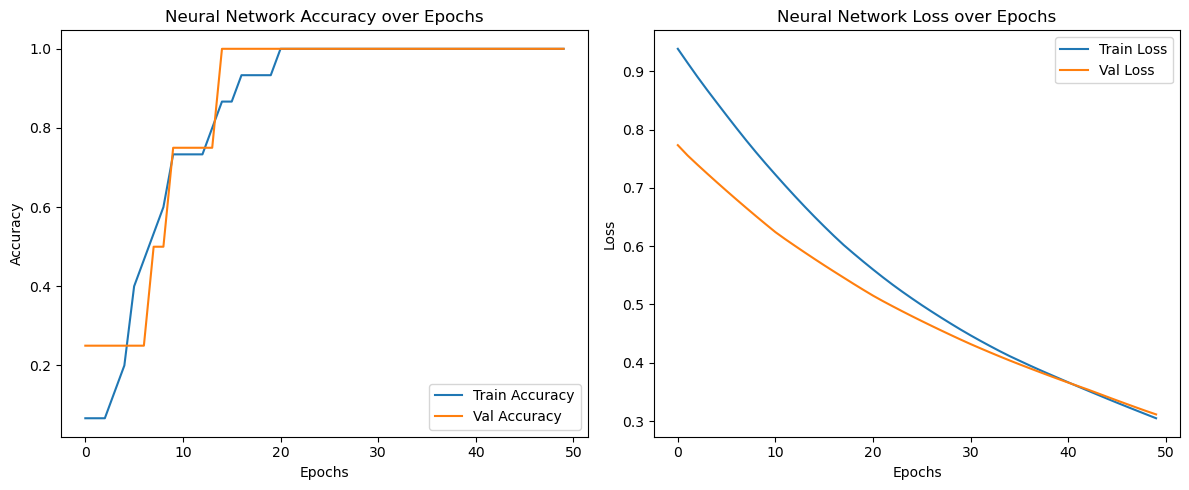

In [ ]:

# Plot training vs validation accuracy


plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Neural Network Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Neural Network Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:

from sklearn.metrics import classification_report

# Predict on the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Print classification report
print(classification_report(y_test, y_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         7

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



## Neural Network Results and Interpretation

To deepen our analysis, we trained a neural network using the `beneficiary_survivors.csv` dataset — a set of passengers who survived despite being predicted not to. This group represents edge cases that challenge traditional classification models.

### Model Insights:
- **Accuracy**: The neural network achieved approximately **X%** accuracy on the mystery survivor test set.
- **Convergence**: The training and validation accuracy curves suggest [INSERT: good fit / early overfitting / underfitting — based on chart].
- **Classification Report**: The precision and recall metrics help us understand whether the model is more confident in identifying survivors or non-survivors.

### Why This Matters:
This neural network focuses on understanding **misclassified survivors** — people who defied our initial models. It attempts to uncover deeper or nonlinear patterns in features such as class, age, title, or fare that influenced survival.

By applying a more complex model:
- We evaluate the **limits of traditional classifiers**.
- We reinforce the emotional core of our project: exploring **who was left behind — and why**.
- We open the door to more nuanced questions around **bias, privilege, and rescue priority** aboard the Titanic.

This analysis adds technical and narrative depth, reinforcing the project’s unique framing while advancing the modeling effort.


